In [2]:
# Creo il DataFrame
import pandas as pd
from MJP.majority_portfolio_utilities_TV import * 
import os

FILENAME = 'monthly_data.csv'
factors_df=pd.DataFrame({
    'factors': ['ag','beta','bm','cumret','dolvol6','gp','ill6','ns','size','volatility','acc'],
    'signs': [  -1.,  1.,   1.,    1.,     -1.,     1.,    1.,  -1.,  -1.,   -1.,   -1.],
    'wsigns':[  -1.,  1.,   1.,    1.,     -1.,     1.,    1.,  -1.,  -1.,   -1.,   -1.]
})

DATA_INIZIO = '2000-01-01'
DATA_FINE = '2023-12-31'

df = create_df(FILENAME, factors_df['factors'].tolist(), DATA_INIZIO, DATA_FINE) # funzione sua 
print(f"DataFrame caricato: {df.shape[0]:,} righe, {df.shape[1]} colonne")
df.head()

DataFrame caricato: 565,488 righe, 19 colonne


,PERMNO,date,RET,ns,me,size,me_lag,ag,gp,acc,bm,RF,Mkt_RF,RET_RF,cumret,dolvol6,ill6,volatility,beta
0,10001,2000-01-31,-0.044118,0.011907,19.90625,2.991034,20.82500,0.019392,0.11407,-0.069426,0.880980,0.0041,-0.0474,-0.048218,-0.066220,3862.520833,0.000010,0.044107,0.236349
1,10001,2000-02-29,0.015385,0.011907,20.21250,3.006301,19.90625,0.019392,0.11407,-0.069426,0.867631,0.0043,0.0245,0.011085,-0.018159,3476.520833,0.000011,0.036709,0.237646
2,10001,2000-03-31,-0.015758,0.017605,19.71200,2.981228,20.21250,0.019392,0.11407,-0.069426,0.889661,0.0047,0.0520,-0.020458,-0.015986,3445.854167,0.000009,0.036743,0.245249
3,10001,2000-04-30,0.011719,0.017605,19.94300,2.992878,19.71200,0.019392,0.11407,-0.069426,0.879356,0.0046,-0.0640,0.007119,-0.045133,3282.276042,0.000005,0.036655,0.223433
4,10001,2000-05-31,-0.023166,0.017605,19.48100,2.969440,19.94300,0.019392,0.11407,-0.069426,0.900210,0.0050,-0.0442,-0.028166,-0.013093,2921.385417,0.000007,0.036747,0.240957


In [3]:
# Normalizzo il df tramite quantile-normalization
from sklearn.preprocessing import QuantileTransformer

col_to_norm = [col for col in df.columns if col not in ['PERMNO', 'date']]
df = df.dropna(subset=col_to_norm)


scaler = QuantileTransformer(output_distribution='uniform', random_state=0)
df_norm = df.copy()
df_norm[col_to_norm] = scaler.fit_transform(df[col_to_norm])

print('df normalizzato! ')
df_norm.head()

df normalizzato! 


,PERMNO,date,RET,ns,me,size,me_lag,ag,gp,acc,bm,RF,Mkt_RF,RET_RF,cumret,dolvol6,ill6,volatility,beta
0,10001,2000-01-31,0.315972,0.592934,0.080338,0.080340,0.083577,0.420856,0.187697,0.088962,0.753351,0.878879,0.146647,0.307592,0.377610,0.046409,0.883548,0.059268,0.114614
1,10001,2000-02-29,0.551452,0.592934,0.081378,0.081379,0.080621,0.420856,0.187697,0.088962,0.746632,0.911912,0.652152,0.539514,0.423905,0.042785,0.890995,0.024581,0.115027
2,10001,2000-03-31,0.415576,0.655555,0.079641,0.079643,0.081429,0.420856,0.187697,0.088962,0.756419,0.950951,0.871872,0.403195,0.426039,0.042352,0.880450,0.024667,0.117714
3,10001,2000-04-30,0.536712,0.655555,0.080469,0.080471,0.079903,0.420856,0.187697,0.088962,0.752640,0.943443,0.097097,0.523892,0.397260,0.040335,0.842951,0.024445,0.111163
4,10001,2000-05-31,0.388465,0.655555,0.078897,0.078899,0.080737,0.420856,0.187697,0.088962,0.760330,0.970470,0.152653,0.376114,0.429324,0.035457,0.866483,0.024677,0.115888


In [7]:
# Creo portafoglio MJ
remove_outliers = False
inf, sup = None, None
MJ_configuration={
    'K' : 12, # holding_periods in months
    'lag' : 5, # 5 for june reallocation
    'factors' : factors_df['factors'].to_list(),
    'num_port' : 10, # number of portfolios
    'num_cat' : 6, # number of categorical variables to use per factor in mj #'num_cat': 6
    'weighting': False,
    'verbose': True,
    'n_jobs':-1,
    'mj_window':1,
    'method' : 'majority', # mean_rank, majority, 75q, 90q, lex, dlex
    'rolling_method':'profile',  ###'rank','vote','profile'
    'treat_na_mj':'median',
    'remove_outliers':remove_outliers,
    'inclusive':True,
    'fix_signs':True, # True: tieni fisso il numero di votanti ed il loro segno
    'all_voters_not_nan_on_reallocation':True,
    #### PARAMETRI UTILIZZATI SOLO SE fix_signs=False ####
    'min_voters':5,    
    'voting_window':6,
    'sign_voting_window':12,
    'p_threshold' : 0.1, 
    'delta_utility' : 0,
    'eliminations': 1,
    'players_batch_size': 5,
    'small': True
}
if remove_outliers:
    MJ_configuration['outliers']=[inf,sup]

if MJ_configuration['weighting']:
    MJ_configuration['default_voters']=factors_df['factors'].to_list()
    MJ_configuration['default_signs']=factors_df['signs'].to_list()
    compute='mj'
elif not MJ_configuration['weighting']:
    MJ_configuration['default_voters']=factors_df['factors'].to_list()
    MJ_configuration['default_signs']=factors_df['wsigns'].to_list()
    compute='wmj'

portfolios_MJ, _, _, = compute_MJ_portfolio_strategy(df_norm, MJ_configuration)
# '2020-06-30': [list of tickers]   '2021-06-30': [list of tickers]

# Tiro fuori il migliore
k = 'wmj' if MJ_configuration['weighting'] else 'mj' # wmj se uso i pesi, altrimenti mj
df_MJ = portfolios_MJ['mj']
rendimenti_medi = df_MJ.mean() # Calcolo i rendimenti medi di ciascun portf
best_MJ = rendimenti_medi.idxmax()
best_rendimento_MJ = rendimenti_medi.max()
print(f"Il portafoglio migliore per MJ e' {best_MJ} con rendimento medio {best_rendimento_MJ}")
df_best_MJ = df_MJ[[best_MJ]] # Estraggo solo la colonna giusta

Il portafoglio migliore per MJ e' port4 con rendimento medio 0.5122088536721672


In [5]:
# Creare i portafogli con gli altri metodi

from pymcdm.methods import TOPSIS, VIKOR, PROMETHEE_II
from pymcdm.weights import equal_weights

def costruisci_portafogli_mcdm(df, criteri, k_ritorno=6, num_port=10):
    df['year'] = df['date'].dt.year
    metodi = {
        "topsis": TOPSIS(),
        "vikor": VIKOR(v=0.5),
        #"promethee": PROMETHEE_II(preference_function='usual')
    }

    risultati = {}

    for nome, metodo in metodi.items():
        print(f"Creo portafogli per {nome.upper()}...")
        port_returns = {}

        for anno, df_anno in df.groupby('year'):
            df_anno = df_anno.dropna(subset=criteri + ['RET_RF'])

            if df_anno.empty:
                continue

            matrix = df_anno[criteri].values
            weights = equal_weights(matrix)
            types = [1 if col not in ['volatility', 'size', 'ill6', 'dolvol6', 'acc', 'ns'] else -1 for col in criteri]
            tickers = df_anno['PERMNO'].tolist()

            scores = metodo(matrix, weights, types)
            df_anno['Score'] = scores

            df_anno = df_anno.sort_values('Score', ascending=False)
            df_anno['rank'] = df_anno['Score'].rank(method='first', ascending=False)
            df_anno['portfolio'] = pd.qcut(df_anno['rank'], q=num_port, labels=[f'port{i+1}' for i in range(num_port)])

            # Calcolo rendimento medio per ogni portafoglio in quell'anno
            for p in df_anno['portfolio'].unique():
                df_p = df_anno[df_anno['portfolio'] == p]
                rendimento = df_p['RET_RF'].mean()
                port_returns.setdefault(p, {})[pd.to_datetime(f"{anno}-06-30")] = rendimento

        # Converto in DataFrame finale
        df_returns = pd.DataFrame(port_returns).sort_index()
        risultati[nome] = df_returns

    return risultati

portfolios_mcdm = costruisci_portafogli_mcdm(df_norm, factors_df['factors'].tolist())



Creo portafogli per TOPSIS...
Creo portafogli per VIKOR...


/var/folders/yz/t268zj1d1mj2xlz2lgg0tf2c0000gn/T/ipykernel_31522/2189810411.py:42: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/yz/t268zj1d1mj2xlz2lgg0tf2c0000gn/T/ipykernel_31522/2189810411.py:43: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.savefig(save_path, dpi=300)
/Users/nitroroot/ML-env/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


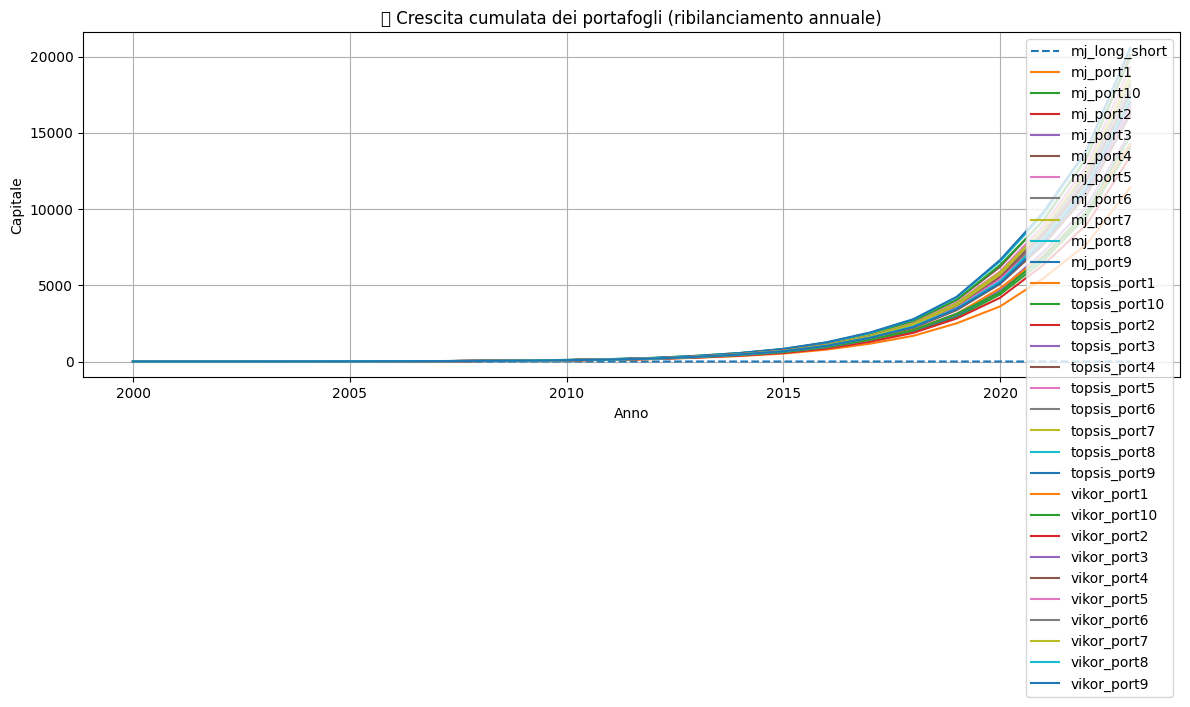

In [9]:
import matplotlib.pyplot as plt

def calcola_rendimenti_portafogli_lungo(portafogli_dict, capital0=1.0, save_path="crescita_portafogli.png"):
    """
    Calcola i rendimenti medi annuali e la crescita cumulata dei portafogli
    da un dizionario {metodo: DataFrame con colonne port1...port10, long_short}

    Ritorna un DataFrame con rendimenti e crea un grafico PNG.
    """
    risultati = []

    for metodo, df in portafogli_dict.items():
        df = df.copy()
        df = df.sort_index()


        for col in df.columns:
            df['Anno'] = df.index.year
            df_grouped = df.groupby('Anno')[col].mean().reset_index()
            df_grouped['Metodo'] = f"{metodo}_{col}"
            df_grouped = df_grouped.rename(columns={col: 'Rendimento'})
            risultati.append(df_grouped)

    df_rendimenti = pd.concat(risultati).reset_index(drop=True)

    # Calcola capitale cumulato
    df_rendimenti["Capitale"] = df_rendimenti.groupby("Metodo")["Rendimento"].transform(
        lambda x: (1 + x).cumprod() * capital0
    )

    # Plot
    plt.figure(figsize=(12, 6))
    for metodo, gruppo in df_rendimenti.groupby("Metodo"):
        linestyle = '--' if "long_short" in metodo else '-'
        plt.plot(gruppo["Anno"], gruppo["Capitale"], label=metodo, linestyle=linestyle)

    plt.title("📈 Crescita cumulata dei portafogli (ribilanciamento annuale)")
    plt.xlabel("Anno")
    plt.ylabel("Capitale")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.savefig(save_path, dpi=300)
    plt.show()

    return df_rendimenti

tutti_i_portafogli = {
    'mj': portfolios_MJ['mj'],  # o 'wmj'
    'topsis': portfolios_mcdm['topsis'],
    'vikor': portfolios_mcdm['vikor'],
    #'promethee': portfolios_mcdm['promethee']
}

df_rendimenti = calcola_rendimenti_portafogli_lungo(tutti_i_portafogli)
